# **Artificial intelligence**
## **Deep Learning**

In [1]:
import warnings
import itertools
warnings.filterwarnings("ignore")


<hr>

### **Introduction**

We wish to train a network to recognize numbers and letters. For this, we use two datasets:
- `mnist` already seen in class,
- `letters` which is a sample extracted from a larger corpus: `emnist`.

In [2]:
import numpy as np
import pandas as pa
import matplotlib.pyplot as plt
import matplotlib.cm as cm


<hr>

### **Preparing the data**

The following cells load data and define the `load_letters` function. This function performs a similar task to the `load_data` function in `mnist`.

<div class="alert alert-block alert-info">
<b>Note:</b> The loading of the corpus may take some time, so the cell should be executed only once.</div>

In [3]:
letters_train = pa.read_csv(
    'https://www.labri.fr/perso/zemmari/datasets/emnist/emnist-letters-train.csv',
    header=None)
letters_test = pa.read_csv(
    'https://www.labri.fr/perso/zemmari/datasets/emnist/emnist-letters-test.csv',
    header=None)


In [4]:
def load_letters():
    # Please note that test labels are in column 0
    X_train = np.array(letters_train.iloc[:, 1:785])
    y_train = np.array(letters_train.iloc[:, 0])
    y_train = y_train - 1
    X_test = np.array(letters_test.iloc[:, 1:785])
    y_test = np.array(letters_test.iloc[:, 0])
    y_test = y_test - 1
    X_train = np.reshape(X_train, (X_train.shape[0], 28, 28))
    X_test = np.reshape(X_test, (X_test.shape[0], 28, 28))
    return (X_train, y_train), (X_test, y_test)


<hr>

### **First part: recognition of numbers**

<hr>

#### **Q1. Load the data and do the necessary formatting.**

- We start by loading the training and test data. So we use the `load_letters` function defined earlier.

- Next, we apply some formatting necessary to be able to use the data correctly, such as converting the data to float32 and normalizing the data from the interval `[0, 255]` to the interval `[0, 1]`.

- Then we convert the labels into vectors of size 26, with a 1 at the label position and 0's elsewhere. We use the `to_categorical` function of `keras.utils` for this.

- Finally, we resize the data with the `reshape` function of `numpy`.

In [5]:
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = load_letters()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0


y_train = to_categorical(y_train, 26)
y_test = to_categorical(y_test, 26)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


2023-08-05 19:43:00.617659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


X_train shape: (88800, 28, 28, 1)
X_test shape: (14800, 28, 28, 1)
y_train shape: (88800, 26)
y_test shape: (14800, 26)


The following code displays the first image of the `letters` training corpus from the `emnist` dataset.

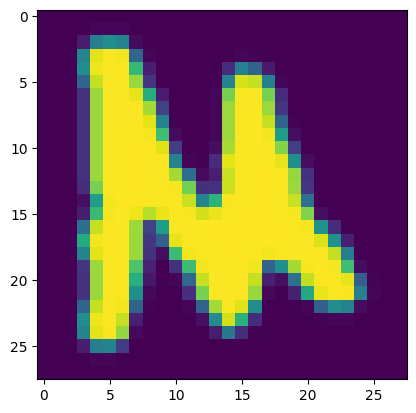

In [6]:
# The image is turned 90° to be displayed
# correctly because it is a letter 'M' turned over
plt.imshow(np.rot90(X_train[0]))


Finally, we shuffle the training and test data.

In [7]:
# Shuffle the training set
shuffle = np.random.permutation(len(X_train))
X_train = X_train[shuffle]
y_train = y_train[shuffle]

# Shuffle the test set
shuffle = np.random.permutation(len(X_test))
X_test = X_test[shuffle]
y_test = y_test[shuffle]


#### **Q2. Define a network to classify letters.**

To define a network for classifying letters, we must first decide on the architecture of the network. There are several ways to design a **neural network**, and the best architecture often depends on the specific characteristics of the data being studied.

We will therefore use a convolutional neural network (CNN) which is particularly well adapted to image classification tasks, given its ability to learn the characteristics of the data through the layers of the network.

<hr>

### **Model #1**

<hr>

The code below describes the following architecture.

- A flattening layer that transforms the feature array into a 1D vector.

- A dense output layer with one unit per class, i.e. 26 classes for the 26 letters of the alphabet. Its activation function `SoftMax` is used to predict a probability for each of the 26 possible letters. Its formula is: $$P(class_i) = \sigma(z) = \frac{e^{z}}{\sum_{j=1}^{K} e^{z_j}}$$

- Where:
    - $\sigma(z)$ is the probability of the input belonging to class $i$.
    - $z_i$ is the output value of the dense output layer for class $i$.
    - K$ is the number of classes.

<br>

- The model is then compiled with the `categorical_crossentropy` loss function, its formula being: $$Loss(p, q) = -\sum_{i=1}^n p_i \log q_i$$

- Where:
    - $p$ is the target probability distribution (i.e. the actual probability distribution).
    - $q$ is the predicted probability distribution (i.e. the probability distribution produced by the model).
    - $n$ is the number of classes.

<br>

- The chosen optimizer is `Adam` (Adaptive Moment Estimation). It is an algorithm inspired by gradient descent but here it is used to adjust the learning rate for each parameter at each time. It is therefore more efficient than the classical gradient descent. Adam adapts to the data and to the `features` of the model which can lead to superior results. His formula is: $$w(t+1) = w(t) - \eta \frac{m(t)}{\sqrt{v(t)} + \epsilon}$$

- Where :
    - $w(t)$ is the current value of the model weights.
    - $\eta$ is the learning rate.
    - $m(t)$ is the estimate of the first moment (mean) of the model gradients.
    - $v(t)$ is the estimate of the second moment (uncentered variance) of the model gradients.
    - $\epsilon$ is a stop condition and avoids division by zero.

<br>

- The metric used is `accuracy`.

In [8]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam


model = Sequential()
model.add(Flatten())
model.add(Dense(26, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(),
              metrics=['accuracy'])

model.build(input_shape=(None, 28, 28, 1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 26)                20410     
                                                                 
Total params: 20,410
Trainable params: 20,410
Non-trainable params: 0
_________________________________________________________________


2023-08-05 19:43:10.739692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Training parameters
batch_size = 32
epochs = 10

# Train the model
history = model.fit(X_train, y_train, validation_data=(
    X_test, y_test), batch_size=batch_size, epochs=epochs)


Epoch 1/10
2775/2775 [==============================] - 5s 2ms/step - loss: 1.2326 - accuracy: 0.6566 - val_loss: 1.0995 - val_accuracy: 0.6895
Epoch 2/10
2775/2775 [==============================] - 4s 2ms/step - loss: 1.0623 - accuracy: 0.7029 - val_loss: 1.0932 - val_accuracy: 0.6943
Epoch 3/10
2775/2775 [==============================] - 4s 1ms/step - loss: 1.0394 - accuracy: 0.7103 - val_loss: 1.0899 - val_accuracy: 0.6939
Epoch 4/10
2775/2775 [==============================] - 5s 2ms/step - loss: 1.0256 - accuracy: 0.7148 - val_loss: 1.1048 - val_accuracy: 0.6900
Epoch 5/10
2775/2775 [==============================] - 4s 2ms/step - loss: 1.0158 - accuracy: 0.7162 - val_loss: 1.0753 - val_accuracy: 0.6974
Epoch 6/10
2775/2775 [==============================] - 4s 2ms/step - loss: 1.0083 - accuracy: 0.7187 - val_loss: 1.0685 - val_accuracy: 0.7035
Epoch 7/10
2775/2775 [==============================] - 4s 1ms/step - loss: 1.0007 - accuracy: 0.7220 - val_loss: 1.0660 - val_accuracy:

Let's define some useful functions to judge the quality of our model.

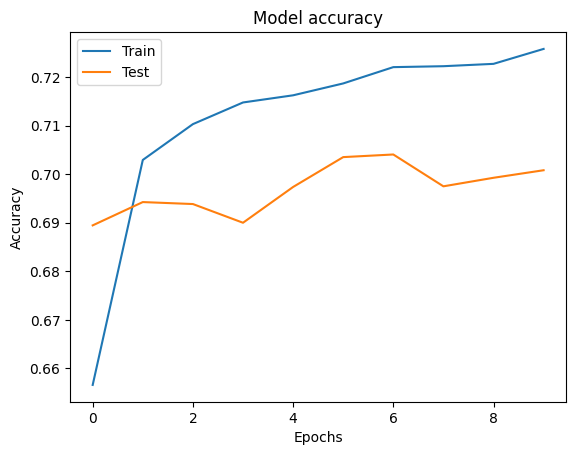

In [10]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


plot_history(history)


In [11]:
print(
    f'Average loss: {np.mean(history.history["loss"]):.4f} per unit of cross-entropy')
print(f'Average accuracy: {np.mean(history.history["accuracy"])*100:.2f}%')


Average loss: 1.0359 per unit of cross-entropy
Average accuracy: 71.12%


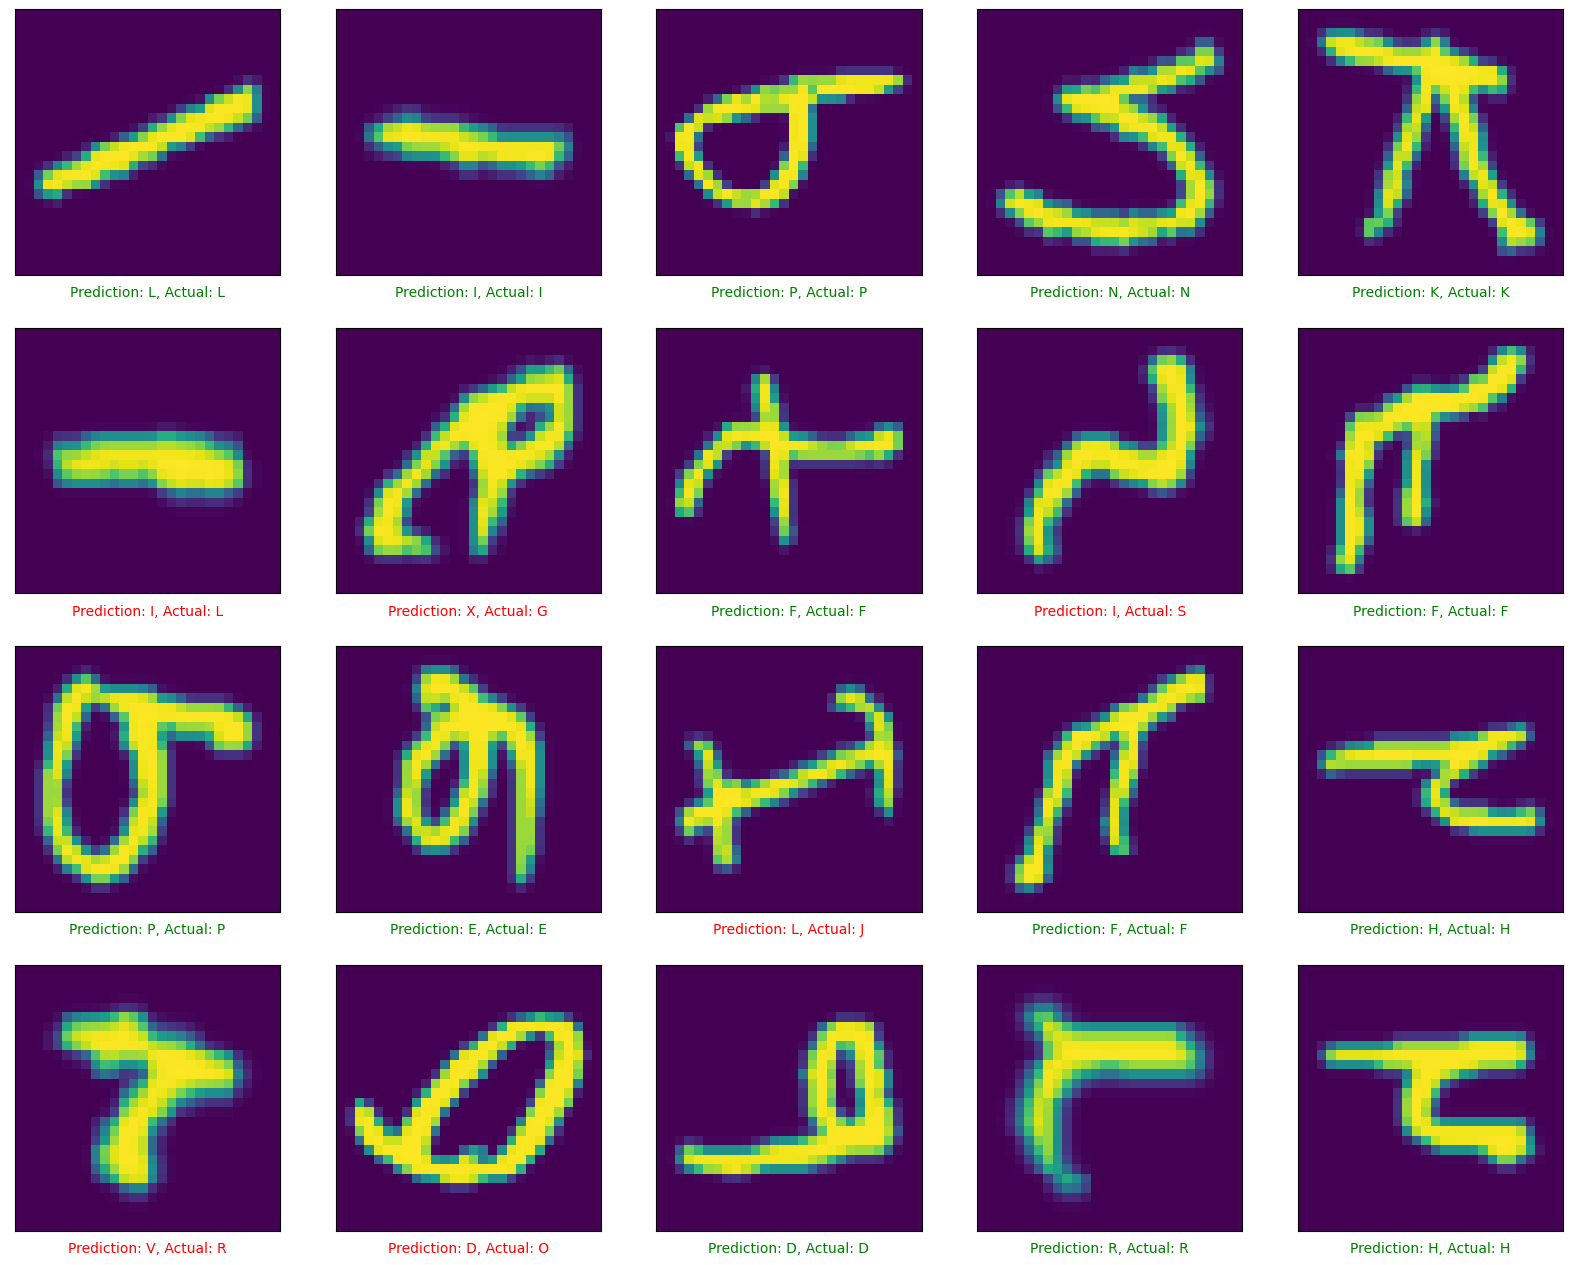

In [12]:
def plot_comparison(X_test, y_test, model):
    plt.figure(figsize=(20, 20))
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_test[i].reshape(28, 28))
        if np.argmax(model.predict(X_test[i].reshape(1, 28, 28, 1), verbose=0)) == np.argmax(y_test[i]):
            plt.xlabel(f'Prediction: {chr(np.argmax(model.predict(X_test[i].reshape(1, 28, 28, 1), verbose=0))+65)}, Actual: {chr(np.argmax(y_test[i])+65)}',
                       color='green')
        else:
            plt.xlabel(f'Prediction: {chr(np.argmax(model.predict(X_test[i].reshape(1, 28, 28, 1), verbose=0))+65)}, Actual: {chr(np.argmax(y_test[i])+65)}',
                       color='red')
    plt.show()


plot_comparison(X_test, y_test, model)


- We can see some small classification errors, like for example the letter `l` which is sometimes confused with the letter `i`.

We can also generate the confusion matrix of the model to evaluate the classification errors.

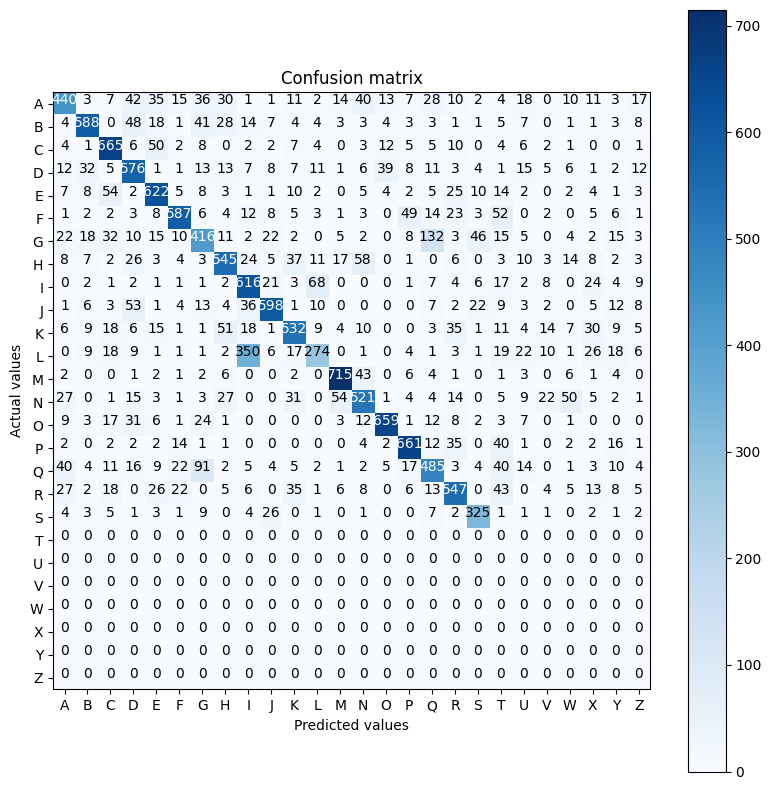

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test, axis=1),
                      np.argmax(model.predict(X_test, verbose=0), axis=1))


def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()

    tick_marks = np.arange(26)
    plt.xticks(tick_marks, [chr(i+65) for i in range(26)])
    plt.yticks(tick_marks, [chr(i+65) for i in range(26)])

    fmt = 'd'
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')
    plt.show()


plot_confusion_matrix(cm)


- Thanks to this matrix, we can already see that there are no letters `t` to `z` in the whole corpus.

- Moreover, we notice that the model is quite efficient since we can see a main diagonal quite clearly.

- On the other hand, we can see outside this main diagonal that the model has made many errors mainly on the letters `g`, `i`, `l` and `q`.

#### **Q3. Test different architectures with different hyperparameters.**

<hr>

### **Model #2**

<hr>

The code below describes the following architecture.

- A 2D convolution layer with 32 filters with a core size of (3, 3). This layer reads in input images of the form (28, 28, 1) i.e. 28x28 pixels grayscale images. The `ReLU` (Rectified Linear Activation) activation function is used to introduce some non-linearity in the model. It is preferred to the `sigmoid` function because it is faster to compute and more efficient. Its formula is: $$f(x) = max(0, x)$$

<br>

- A layer similar to the first one, but with 64 filters this time.

- A `Max Pooling` layer with a pool size of (2, 2). This layer reduces the size of the images produced by the convolution layer by taking the maximum of each 2x2 sub-region of the image. This layer thus reduces the number of parameters to be trained and reduces the complexity of the model, while keeping the most important `features` of the image.

- A dropout layer of rate 0.25, i.e. 1/4 of the neurons will be ignored during each iteration of the model training. This method reduces overfitting by preventing the neurons from becoming too dependent on each other, and thus prevents the model from being too close to the training corpus.

- A flattening layer that transforms the feature array into a 1D vector.

- A dense output layer with one unit per class, i.e. 26 classes for the 26 letters of the alphabet. Its activation function `SoftMax` is used to predict a probability for each of the 26 possible letters.

- The model is then compiled with the loss function `categorical_crossentropy`.

- The chosen optimizer is `Adam`.

- The metric used is `accuracy`.

In [14]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(26, activation='softmax'))


model2.compile(loss='categorical_crossentropy', optimizer=Adam(),
               metrics=['accuracy'])

model2.build(input_shape=(None, 28, 28, 1))
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 26)                239642    
                                                      

<div class="alert alert-block alert-warning">
    <b>Warning:</b> You don't have to run the cell below, it is only there to reduce the total amount of data processed and the number of model training iterations to save time when running the notebook.
</div>

In [15]:
# Reduction of the number of examples to speed up the execution
len_X_train = len(X_train)
X_train = X_train[:len_X_train//4]
y_train = y_train[:len_X_train//4]
len_X_test = len(X_test)
X_test = X_test[:len_X_test//4]
y_test = y_test[:len_X_test//4]

# Reduction of the number of epochs to speed up the execution
epochs = 5


In [16]:
history2 = model2.fit(X_train, y_train, validation_data=(
    X_test, y_test), batch_size=batch_size, epochs=epochs)


Epoch 1/5
694/694 [==============================] - 34s 48ms/step - loss: 0.8127 - accuracy: 0.7566 - val_loss: 0.5304 - val_accuracy: 0.8378
Epoch 2/5
694/694 [==============================] - 33s 47ms/step - loss: 0.4139 - accuracy: 0.8714 - val_loss: 0.4512 - val_accuracy: 0.8562
Epoch 3/5
694/694 [==============================] - 32s 46ms/step - loss: 0.3234 - accuracy: 0.8984 - val_loss: 0.4083 - val_accuracy: 0.8751
Epoch 4/5
694/694 [==============================] - 32s 46ms/step - loss: 0.2664 - accuracy: 0.9150 - val_loss: 0.4231 - val_accuracy: 0.8678
Epoch 5/5
694/694 [==============================] - 31s 44ms/step - loss: 0.2238 - accuracy: 0.9245 - val_loss: 0.4437 - val_accuracy: 0.8678


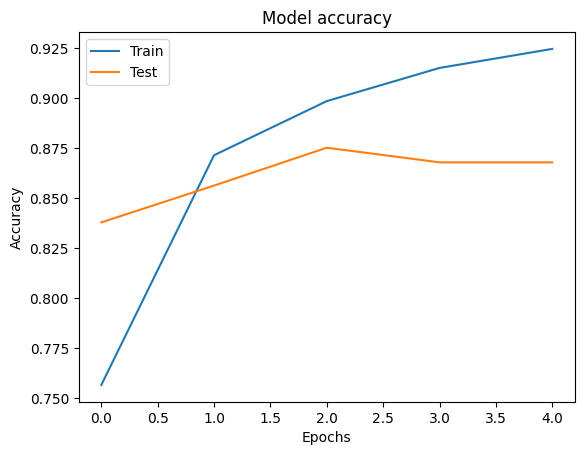

In [17]:
plot_history(history2)


In [18]:
print(
    f'Average loss: {np.mean(history2.history["loss"]):.4f} per unit of cross-entropy')
print(f'Average accuracy: {np.mean(history2.history["accuracy"])*100:.2f}%')


Average loss: 0.4081 per unit of cross-entropy
Average accuracy: 87.32%


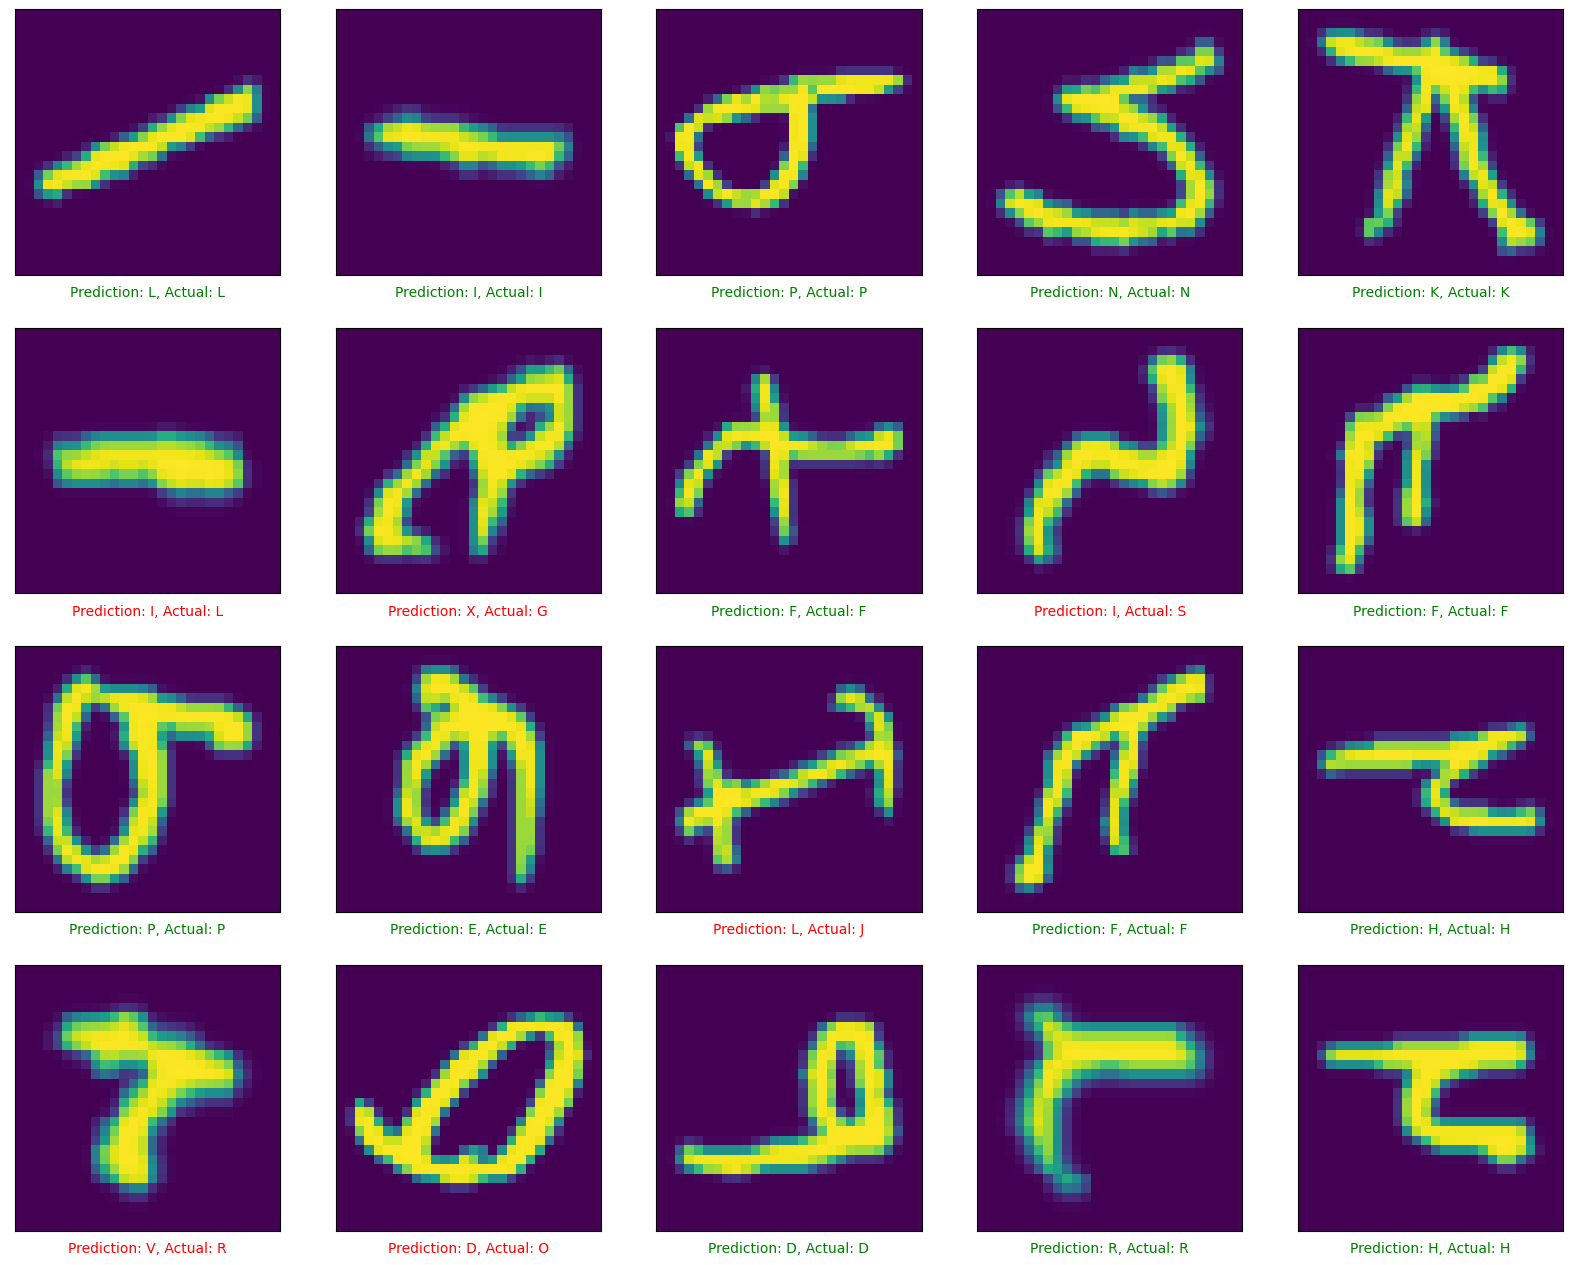

In [19]:
plot_comparison(X_test, y_test, model)


- Still some small errors on the same letters as before but to a lesser extent.

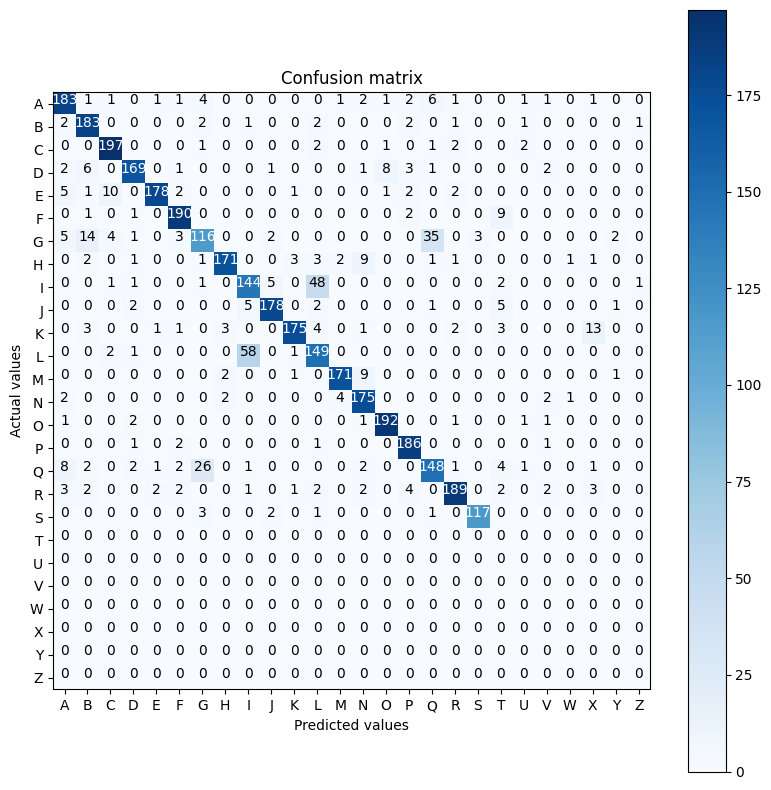

In [20]:
cm = confusion_matrix(np.argmax(y_test, axis=1),
                      np.argmax(model2.predict(X_test, verbose=0), axis=1))

plot_confusion_matrix(cm)


- The main diagonal is even more clearly visible than before.

#### **Q4. Explain each time your choices and your results.**

- Due to their architecture, Model #1 is a simple neural network that can be used for two-class or multi-class classification tasks, while Model #2 is a more complex neural network that can be used for image classification or image processing tasks.

- Model #2 generally performs better than Model #1 for image classification tasks, as it uses convolution and Max Pooling layers to extract features from the input data and reduce their dimensionality.

- However, Model #2 generally requires more time and training data than Model#1, as it is more complex and needs more parameters to optimize.

<hr>

### **Second part: recognition of letters and numbers**

<hr>

We now want to have a network that can classify an image either as a letter or a number.

#### **Q1. Do the necessary manipulations to build your data set.**

You can use the two functions `load_data()` from `mnist` and `load_letters()` from the previous cell.

In [21]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train_letters, y_train_letters), (X_test_letters, y_test_letters) = load_letters()

# Set labels to 0 for numbers and 1 for letters
y_train = np.zeros(y_train.shape)
y_test = np.zeros(y_test.shape)
y_train_letters = np.ones(y_train_letters.shape)
y_test_letters = np.ones(y_test_letters.shape)

# Concatenate data
X_train = np.concatenate((X_train, X_train_letters))
X_test = np.concatenate((X_test, X_test_letters))
y_train = np.concatenate((y_train, y_train_letters))
y_test = np.concatenate((y_test, y_test_letters))

# Data normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encoding of the labels
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (148800, 28, 28, 1)
X_test shape: (24800, 28, 28, 1)
y_train shape: (148800, 2)
y_test shape: (24800, 2)


In [22]:
shuffle = np.random.permutation(len(X_train))
X_train = X_train[shuffle]
y_train = y_train[shuffle]

shuffle = np.random.permutation(len(X_test))
X_test = X_test[shuffle]
y_test = y_test[shuffle]


<hr>

### **Model #3**

<hr>

Let's use the same intuition as in Part 1, and define a simple architecture, similar to Model #1.

In [23]:
model3 = Sequential()
model3.add(Flatten())
model3.add(Dense(2, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer=Adam(),
               metrics=['accuracy'])

model3.build(input_shape=(None, 28, 28, 1))
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1570      
                                                                 
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________


In [24]:
epochs = 10

history3 = model3.fit(X_train, y_train, validation_data=(
    X_test, y_test), batch_size=batch_size, epochs=epochs)


Epoch 1/10
4650/4650 [==============================] - 7s 1ms/step - loss: 0.1751 - accuracy: 0.9341 - val_loss: 0.1436 - val_accuracy: 0.9453
Epoch 2/10
4650/4650 [==============================] - 7s 1ms/step - loss: 0.1503 - accuracy: 0.9448 - val_loss: 0.1499 - val_accuracy: 0.9415
Epoch 3/10
4650/4650 [==============================] - 6s 1ms/step - loss: 0.1466 - accuracy: 0.9466 - val_loss: 0.1416 - val_accuracy: 0.9460
Epoch 4/10
4650/4650 [==============================] - 6s 1ms/step - loss: 0.1455 - accuracy: 0.9468 - val_loss: 0.1352 - val_accuracy: 0.9487
Epoch 5/10
4650/4650 [==============================] - 8s 2ms/step - loss: 0.1448 - accuracy: 0.9473 - val_loss: 0.1427 - val_accuracy: 0.9438
Epoch 6/10
4650/4650 [==============================] - 6s 1ms/step - loss: 0.1443 - accuracy: 0.9473 - val_loss: 0.1355 - val_accuracy: 0.9502
Epoch 7/10
4650/4650 [==============================] - 6s 1ms/step - loss: 0.1442 - accuracy: 0.9474 - val_loss: 0.1370 - val_accuracy:

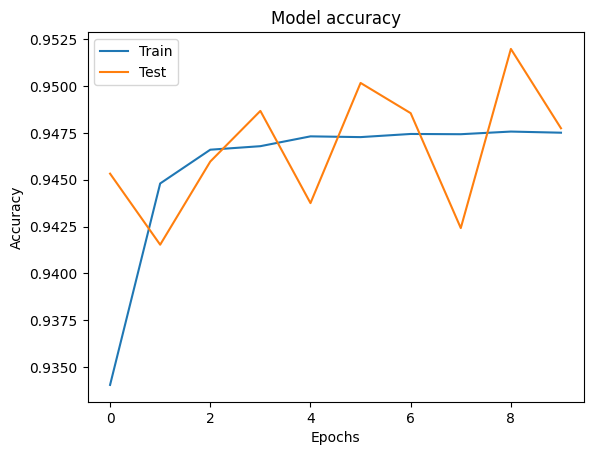

In [25]:
plot_history(history3)


In [26]:
print(
    f'Average loss: {np.mean(history3.history["loss"]):.4f} per unit of cross-entropy')
print(f'Average accuracy: {np.mean(history3.history["accuracy"])*100:.2f}%')


Average loss: 0.1483 per unit of cross-entropy
Average accuracy: 94.57%


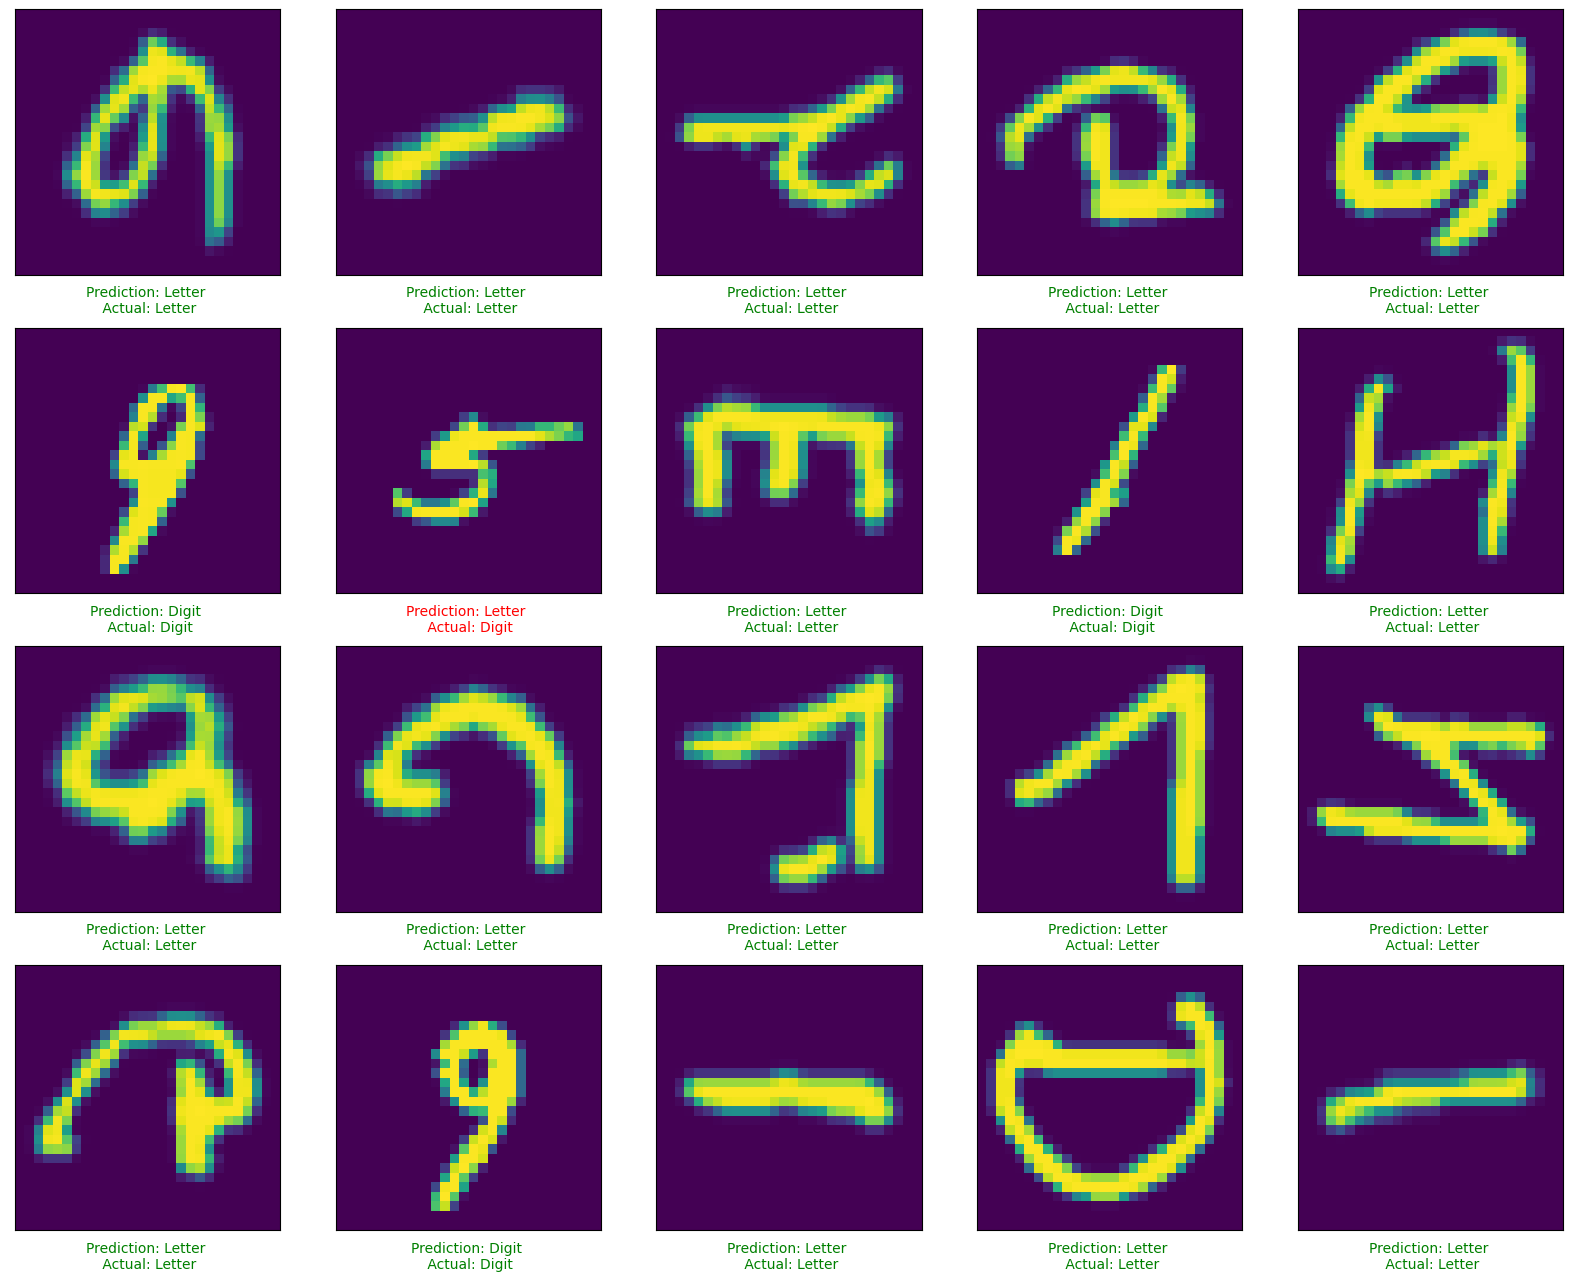

In [27]:
def plot_comparison(X_test, y_test, model):
    plt.figure(figsize=(20, 20))
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_test[i].reshape(28, 28))

        pred = model.predict(X_test[i].reshape(1, 28, 28, 1), verbose=0)
        actual = np.argmax(y_test[i])
        actual = 'Digit' if actual == 0 else 'Letter'
        pred = 'Digit' if pred[0][0] > 0.5 else 'Letter'

        if actual == pred:
            plt.xlabel(
                f'Prediction: {pred} \n Actual: {actual}', color='green')
        else:
            plt.xlabel(f'Prediction: {pred} \n Actual: {actual}', color='red')
    plt.show()


plot_comparison(X_test, y_test, model3)


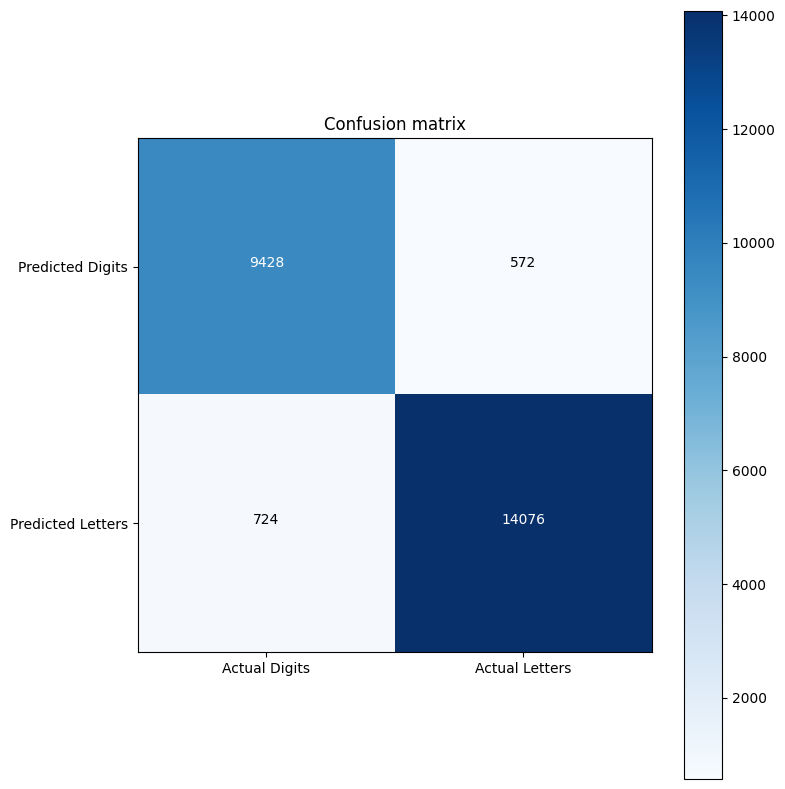

In [28]:
cm = confusion_matrix(np.argmax(y_test, axis=1),
                      np.argmax(model3.predict(X_test, verbose=0), axis=1))


def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Actual Digits', 'Actual Letters'])
    plt.yticks(tick_marks, ['Predicted Digits', 'Predicted Letters'])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


plot_confusion_matrix(cm)


- A model with only two layers that is already very good, with an accuracy of about 94%, and therefore performs well.

- It is therefore possible to say that the two corpora, of letters and numbers, are characterized enough for the model to distinguish them without too much difficulty.

- As for the model, it is quite simple and does not require much data to be trained.

- It is nevertheless possible to try to improve the results by using a more complex model.

<hr>

### **Model #4**

<hr>

#### **Q2. Define, test, and explain architectures to differentiate the two categories.**

Let's improve Model #3 using an architecture similar to Model #2.

In [29]:
model4 = Sequential()
model4.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu', input_shape=(28, 28, 1)))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(2, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer=Adam(),
               metrics=['accuracy'])

model4.build(input_shape=(None, 28, 28, 1))
model4.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 18434     
                                                      

<div class="alert alert-block alert-warning">
    <b>Warning:</b> Same case as for Model #2, you do not have to launch the cell below.
</div>

In [30]:
len_X_train = len(X_train)
X_train = X_train[:len_X_train//4]
y_train = y_train[:len_X_train//4]
len_X_test = len(X_test)
X_test = X_test[:len_X_test//4]
y_test = y_test[:len_X_test//4]

epochs = 5


In [31]:
history4 = model4.fit(X_train, y_train, validation_data=(
    X_test, y_test), batch_size=batch_size, epochs=epochs)


Epoch 1/5
1163/1163 [==============================] - 53s 45ms/step - loss: 0.0664 - accuracy: 0.9757 - val_loss: 0.0190 - val_accuracy: 0.9932
Epoch 2/5
1163/1163 [==============================] - 49s 42ms/step - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0149 - val_accuracy: 0.9945
Epoch 3/5
1163/1163 [==============================] - 50s 43ms/step - loss: 0.0127 - accuracy: 0.9956 - val_loss: 0.0080 - val_accuracy: 0.9973
Epoch 4/5
1163/1163 [==============================] - 50s 43ms/step - loss: 0.0077 - accuracy: 0.9972 - val_loss: 0.0154 - val_accuracy: 0.9953
Epoch 5/5
1163/1163 [==============================] - 50s 43ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0084 - val_accuracy: 0.9973


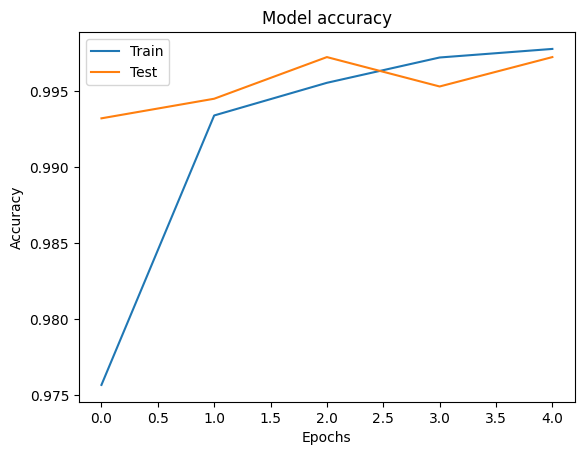

In [32]:
plot_history(history4)


In [33]:
print(
    f'Average loss: {np.mean(history4.history["loss"]):.4f} per unit of cross-entropy')
print(f'Average accuracy: {np.mean(history4.history["accuracy"])*100:.2f}%')


Average loss: 0.0229 per unit of cross-entropy
Average accuracy: 99.19%


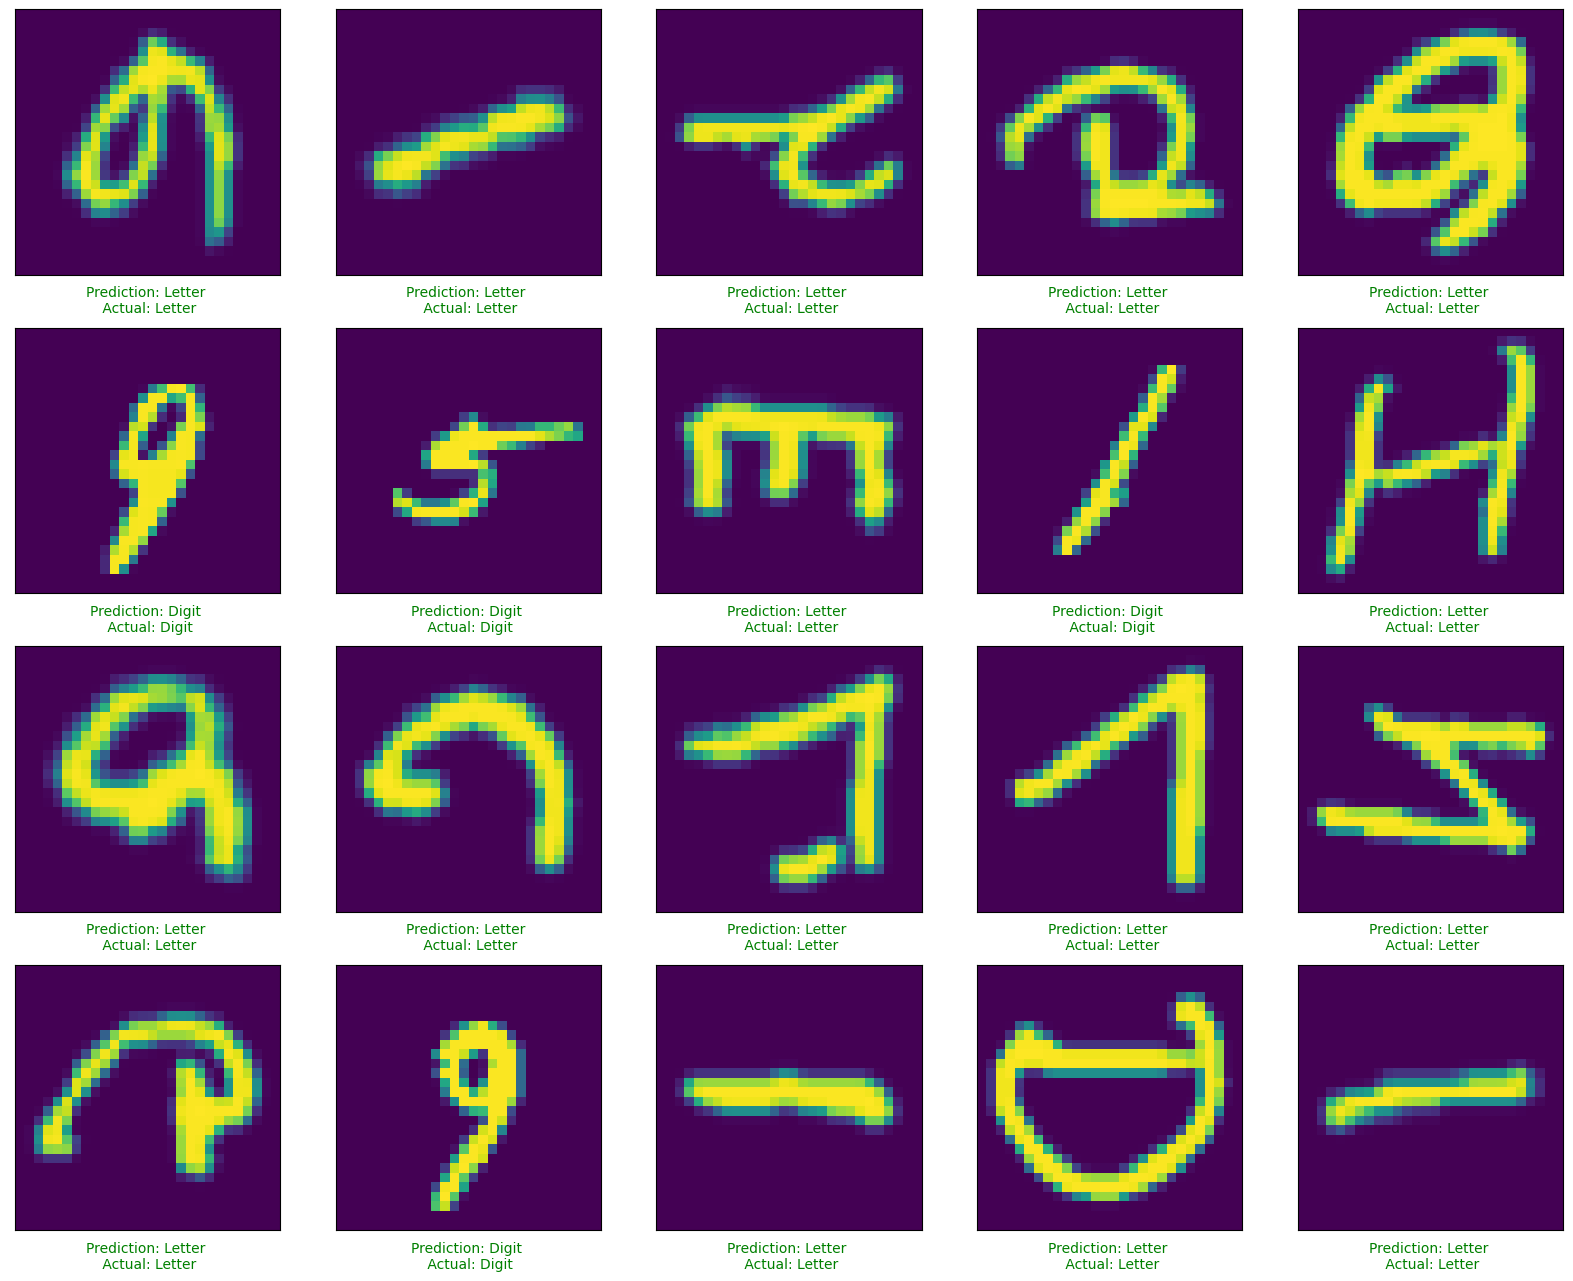

In [34]:
plot_comparison(X_test, y_test, model4)


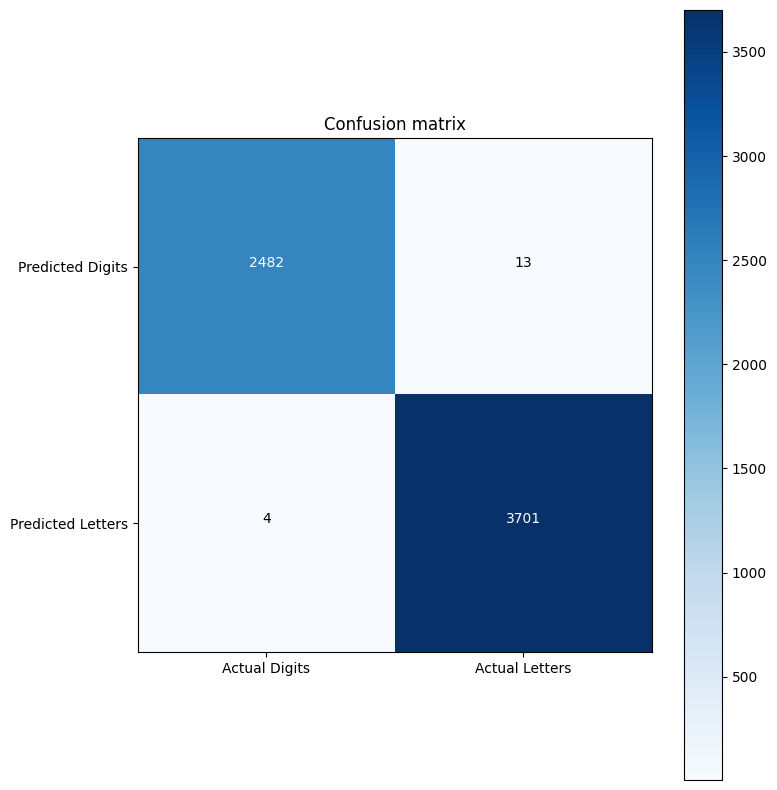

In [35]:
cm = confusion_matrix(np.argmax(y_test, axis=1),
                      np.argmax(model4.predict(X_test, verbose=0), axis=1))

plot_confusion_matrix(cm)


- In the end, a more complex model with very little loss and an accuracy of 99% on the test set.

- The confusion matrix is very clear, and the prediction examples are very good.

- It is useless to push further the architecture of the model, because it is already very powerful.

- Of course it is always possible to try to improve the results by using an even more complex model, but this would take a lot of time and resources.

#### **Q2 (continued). Explain your choices and results each time.**

- Due to their architecture, Model #3 is simpler than Model #4.

- However, Model #3 is much less demanding but is faster to train and predict.

- Model #4 is the more accurate of the two models because it is more complex and needs more parameters to optimize. It is the more suitable for differentiating the two categories of data.